In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

path = "/Users/matteo/Projects/MFI_Florian"
os.chdir(path)

from pyMFI import MFI

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 18})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)



# define custom color scheme
colors = [plt.cm.Spectral(i/float(10-1)) for i in range(10)]

#for i in range(10):
#    plt.scatter(i, i, color=colors[i], s=500)

cs = {
    "Bordeaux": colors[0],
    "Light Red": colors[1],
    "Orange": colors[2],
    "Gold": colors[3],
    "Yellow": colors[4],
    "Lime": colors[5],
    "Light Green": colors[6],
    "Teal": colors[7],
    "Blue": colors[8],
    "Purple": colors[9]
}

In [2]:
path_data = "/Users/matteo/Projects/MFI_Florian/"
#path_data = "/Users/matteo/Projects/MFI_Florian/new_data/WT_MTD/2/"

kT=2
# #Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name=path_data + "HILLS")
#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name=path_data + "colvar.out")
#Read bias and analytical variables
bias = np.loadtxt(path_data + "bias.out")
[analytical_x, analytical_y] = MFI.load_position_2D(position_name=path_data + "colvarRW.out")

#Define the number of HILLS to be analysed
NH=30000

maxx=(np.max(position_x))
minx=(np.min(position_x))
maxy=(np.max(position_y))
miny=(np.min(position_y))

steps=bias[:2*NH,0]/2*1000

In [3]:
#Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.01, kT = kT, log_pace = 100, WellTempered=0, nhills=NH,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))
end=time.time()
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

|**************************************************| 99% | Average Mean Force Error: 322.97026653419135

In [4]:
#Compute FES by solving the inverse gradient problem
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))

In [5]:
#Compute c(t) and sample weights
[expC,BIAS2Dfinal]=MFI.coft(HILLS=HILLS,FES=FES,kT=kT,total_number_of_hills=NH,stride=2,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))
c=kT*np.log(expC)
weights=np.exp(bias[:2*NH-1,1]/kT-c/kT)

|**************************************************| 99% | exp(c(t)/kT): 1540694.5299103974

In [6]:
#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[Prewe,Xrewe,Yrewe]=np.histogram2d(analytical_x[:2*NH-1]**(1/3), analytical_y[:2*NH-1]**(1/3),bins=50,weights=weights)
Prewe = Prewe.T
Frewe = -kT*np.log(Prewe)-np.min(-kT*np.log(Prewe))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


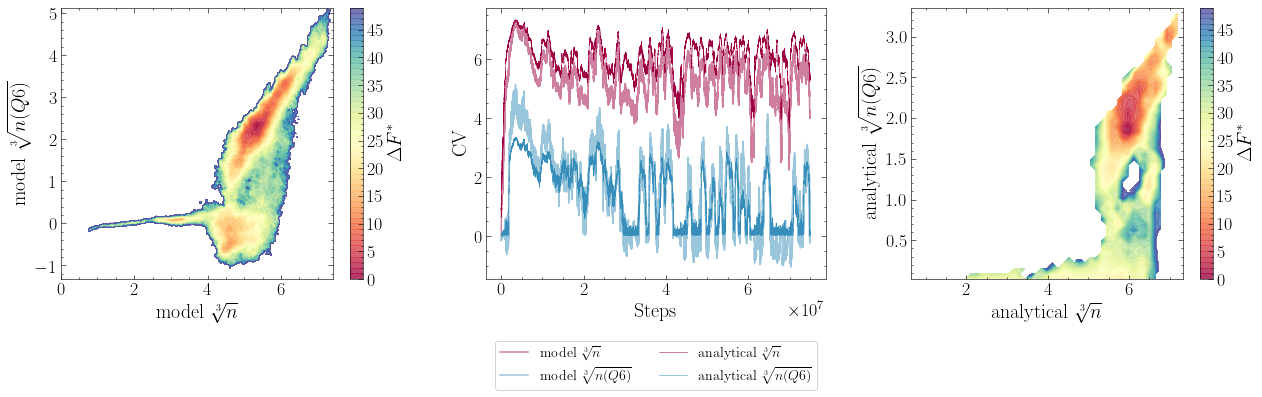

In [7]:
#Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 50, 1), cmap='Spectral', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("$\Delta F^*$",fontsize=20)
axs[0].set_ylabel('model $\sqrt[3]{n(Q6)}$',fontsize=20)
axs[0].set_xlabel('model $\sqrt[3]{n}$',fontsize=20)
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))

axs[1].plot(steps,position_x[0:2*NH],color=colors[0],alpha=0.5,label="model $\sqrt[3]{n}$")
axs[1].plot(steps,position_y[0:2*NH],color=colors[8],alpha=0.5,label="model $\sqrt[3]{n(Q6)}$")
axs[1].set_xlabel('Steps',fontsize=20)
axs[1].set_ylabel('CV',fontsize=20)

axs[1].plot(steps,analytical_x[0:2*NH]**(1/3),'-',color=colors[0],LineWidth=0.5,label='analytical $\sqrt[3]{n}$')
axs[1].plot(steps,analytical_y[0:2*NH]**(1/3),'-',color=colors[8],LineWidth=0.5,label='analytical $\sqrt[3]{n(Q6)}$')

axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=2,fontsize=14)

axs[2].contourf(Xrewe[:-1], Yrewe[:-1],Frewe,cmap='Spectral',levels=np.arange(0, 50, 1), antialiased=False, alpha=0.8)
axs[2].set_ylabel('analytical $\sqrt[3]{n(Q6)}$',fontsize=20)
axs[2].set_xlabel('analytical $\sqrt[3]{n}$',fontsize=20)
axs[2].set_xlim(np.min(Xrewe),np.max(Xrewe))
axs[2].set_ylim(np.min(Yrewe),np.max(Yrewe))

cbar = plt.colorbar(cp, ax=axs[2])
cbar.set_label("$\Delta F^*$",fontsize=20)

fig.tight_layout()    

plt.savefig('metaD_reweight_METAD', dpi=600, bbox_inches='tight')


Text(0, 0.5, '$F$ ')

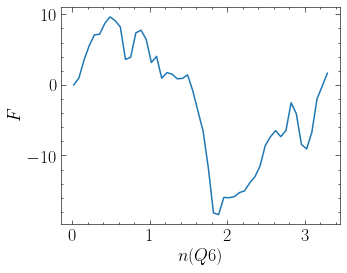

In [8]:
F2=-kT*np.log(np.sum(Prewe,axis=1))-(-kT*np.log(np.sum(Prewe,axis=1)[0]))

plt.plot(Yrewe[:-1],F2)
plt.xlabel('$n(Q6)$')
plt.ylabel('$F$ ')

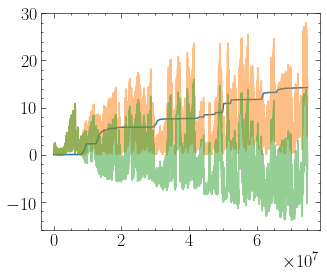

In [9]:
plt.plot(steps[:-1],c/kT)
plt.plot(steps[:-1],bias[:2*NH-1,1]/kT,alpha=0.5)
plt.plot(steps[:-1],bias[:2*NH-1,1]/kT-c/kT,alpha=0.5)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


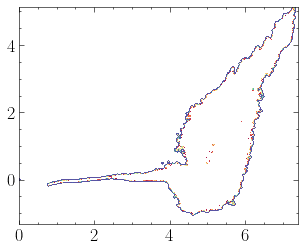

In [10]:
plt.contourf(X, Y, -kT*np.log(Ftot_den),cmap='Spectral', antialiased=False, alpha=0.8,levels=np.arange(0, 8, 0.1))

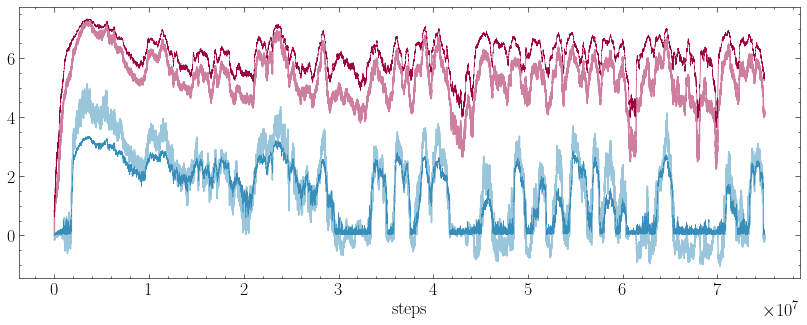

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(14, 5))

axs.plot(steps,position_x[0:2*NH],color=colors[0],alpha=0.5)
axs.plot(steps,position_y[0:2*NH],color=colors[8],alpha=0.5)
axs.set_xlabel('steps')

axs.plot(steps,analytical_x[0:2*NH]**(1/3),'-',color=colors[0],LineWidth=0.5)
axs.plot(steps,analytical_y[0:2*NH]**(1/3),'-',color=colors[8],LineWidth=0.5)

Text(0, 0.5, 'analytical $n^{1/3}$')

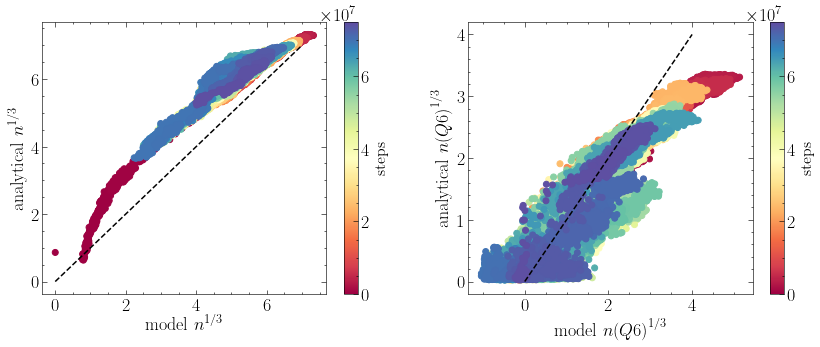

In [12]:
end=2*NH


fig, axs = plt.subplots(1, 2, figsize=(14, 5))
plot=axs[0].scatter(position_x[0:end],analytical_x[0:end]**(1/3),c=steps[0:end],alpha=1,cmap='Spectral')
axs[1].scatter(position_y[0:end],analytical_y[0:end]**(1/3),c=steps[0:end],alpha=1,cmap='Spectral')
cbar = plt.colorbar(plot, ax=axs[1])
cbar.set_label("steps",fontsize=16)
cbar = plt.colorbar(plot, ax=axs[0])
cbar.set_label("steps",fontsize=16)
axs[0].plot(np.arange(8),np.arange(8),'k--')
axs[1].plot(np.arange(5),np.arange(5),'k--')
axs[1].set_ylabel('analytical ${n(Q6)}^{1/3}$')
axs[1].set_xlabel('model ${n(Q6)}^{1/3}$')
axs[0].set_xlabel('model $n^{1/3}$')
axs[0].set_ylabel('analytical $n^{1/3}$')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


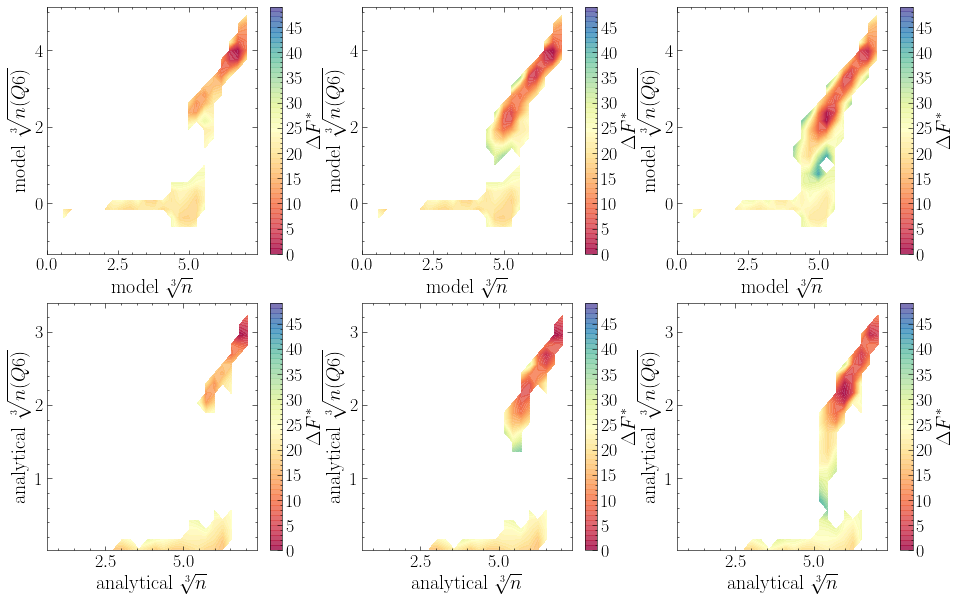

In [13]:
#convergence analysis
start=0

fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for block in range(3):
    stop=int(start+7000)
    indexes=np.arange(0,stop,1,dtype=int)
    [Prewe,Xrewe,Yrewe]=np.histogram2d(position_x[indexes], position_y[indexes],bins=25,weights=weights[indexes])
    Prewe = Prewe.T
    Frewe = -kT*np.log(Prewe)-np.min(-kT*np.log(Prewe))
    
    plot0=axs[0,block].contourf(Xrewe[:-1], Yrewe[:-1],Frewe,cmap='Spectral',levels=np.arange(0,50, 1), antialiased=False, alpha=0.8)
    
    axs[0,block].set_ylabel('model $\sqrt[3]{n(Q6)}$',fontsize=20)
    axs[0,block].set_xlabel('model $\sqrt[3]{n}$',fontsize=20)
    axs[0,block].set_xlim(np.min(Xrewe),np.max(Xrewe))
    axs[0,block].set_ylim(np.min(Yrewe),np.max(Yrewe))
    cbar = plt.colorbar(plot0, ax=axs[0,block])
    cbar.set_label("$\Delta F^*$",fontsize=20)
    axs[0,block].set_xlim(np.min(position_x),np.max(position_x))
    axs[0,block].set_ylim(np.min(position_y),np.max(position_y))
 
    [Prewe,Xrewe,Yrewe]=np.histogram2d(analytical_x[indexes]**(1/3), analytical_y[indexes]**(1/3),bins=25,weights=weights[indexes])
    Prewe = Prewe.T
    Frewe = -kT*np.log(Prewe)-np.min(-kT*np.log(Prewe))
    plot1=axs[1,block].contourf(Xrewe[:-1], Yrewe[:-1],Frewe,cmap='Spectral',levels=np.arange(0, 50, 1), antialiased=False, alpha=0.8)
    axs[1,block].set_ylabel('analytical $\sqrt[3]{n(Q6)}$',fontsize=20)
    axs[1,block].set_xlabel('analytical $\sqrt[3]{n}$',fontsize=20)

    axs[1,block].set_xlim(np.min(Xrewe),np.max(Xrewe))
    axs[1,block].set_ylim(np.min(Yrewe),np.max(Yrewe))
    cbar = plt.colorbar(plot1, ax=axs[1,block])
    cbar.set_label("$\Delta F^*$",fontsize=20)
    axs[1,block].set_xlim(np.min(analytical_x**(1/3)),np.max(analytical_x**(1/3)))
    axs[1,block].set_ylim(np.min(analytical_y**(1/3)),np.max(analytical_y**(1/3)))
   
    
    start=stop
    
plt.savefig('convergence_WT1', dpi=600, bbox_inches='tight')


In [14]:
weights[(np.arange(start,stop,1,dtype=int))]

array([], dtype=float64)